In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from models import EEGNetHybridNorm

class BCI2DCursorEnv(gym.Env):

    def __init__(self, eeg_segments, labels, sl_model_path,
                 feature_npz_path=None, method='hybrid', success_radius=2.0):
        super().__init__()

        self.eeg_segments = eeg_segments
        self.labels = labels
        self.num_segments = len(eeg_segments)
        self.segment_len = eeg_segments.shape[1]
        self.success_radius = float(success_radius)

        self.method = method
        self.grid_size = 20
        self.max_steps = self.segment_len  # ALWAYS = number of EEG trials

        # =========================
        # Load SL only when needed
        # =========================
        if method in ['sl-only', 'sl-rl', 'hybrid']:
            self.sl_decoder = self._load_sl_decoder(sl_model_path)
        else:
            self.sl_decoder = None   # rl-only baseline

        # Hybrid feature bank
        if method == 'hybrid' and feature_npz_path is not None:
            self.feature_bank = np.load(feature_npz_path)["features"]
            print(f" Hybrid : {self.feature_bank.shape}")
        else:
            self.feature_bank = None

        # Action space
        self.action_space = spaces.Discrete(4)

        # ============================
        # Observation space dimension
        # ============================
        if method == 'sl-only':
            self.observation_space = spaces.Box(-1, 1, shape=(4,), dtype=np.float32)
        elif method == 'sl-rl':
            self.observation_space = spaces.Box(-1, 1, shape=(8,), dtype=np.float32)
        elif method == 'rl-only':
            self.observation_space = spaces.Box(-1, 1, shape=(4,), dtype=np.float32)
        else:
            self.observation_space = spaces.Box(-1, 1, shape=(168,), dtype=np.float32)

        self.current_segment_idx = None
        self.current_segment = None
        self.segment_labels = None
        self.trial_ptr = 0
        self.cursor_pos = None
        self.target_pos = None
        self._last_distance = None
        self.steps = 0

    # ====================================
    # SL decoder
    # ====================================
    def _load_sl_decoder(self, path):
        model = EEGNetHybridNorm(num_classes=4, num_channels=22, sample_length=1000)
        model.load_state_dict(torch.load(path, map_location="cpu"))
        model.eval()
        print(f" SL : {path}")
        return model

    def _get_sl_probabilities(self, eeg_signal):
        if self.sl_decoder is None:
            return np.zeros(4, dtype=np.float32)  # for rl-only
        
        with torch.no_grad():
            eeg_tensor = torch.FloatTensor(eeg_signal).unsqueeze(0).unsqueeze(0)
            probs = self.sl_decoder(eeg_tensor)
            probs = F.softmax(probs, dim=1).cpu().numpy().flatten()
            return probs.astype(np.float32)

    def _get_eeg_features(self):
        if self.feature_bank is None:
            return np.zeros(160, dtype=np.float32)

        global_idx = self.current_segment_idx * self.segment_len + self.trial_ptr
        feats = self.feature_bank[global_idx]
        if feats.shape[0] > 160:
            feats = feats[:160]
        return feats.astype(np.float32)

    # ====================================
    # State builder
    # ====================================
    def _build_state(self, eeg_signal):
        sl_probs = self._get_sl_probabilities(eeg_signal)

        if self.method == 'sl-only':
            return sl_probs

        elif self.method == 'sl-rl':
            return np.concatenate([sl_probs, self.cursor_pos, self.target_pos]).astype(np.float32)

        elif self.method == 'rl-only':
            # RL-only baseline: no EEG, only positions
            return np.concatenate([self.cursor_pos, self.target_pos]).astype(np.float32)

        else:  # hybrid
            eeg_features = self._get_eeg_features()
            return np.concatenate([eeg_features, sl_probs, self.cursor_pos, self.target_pos]).astype(np.float32)

    # ====================================
    # Reset
    # ====================================
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.current_segment_idx = np.random.randint(0, self.num_segments)
        self.current_segment = self.eeg_segments[self.current_segment_idx]
        self.segment_labels = self.labels[self.current_segment_idx]

        self.trial_ptr = 0
        self.steps = 0

        # Cursor
        self.cursor_pos = np.array([self.grid_size//2, self.grid_size//2], dtype=np.float32)

        # Target from label
        target_offsets = {1: [-5, 0], 2: [5, 0], 3: [0, -5], 4: [0, 5]}
        label = int(self.segment_labels[-1])
        offset = np.array(target_offsets.get(label, [0, 0]))
        self.target_pos = np.clip(self.cursor_pos + offset, 0, self.grid_size-1)

        self._last_distance = np.linalg.norm(self.cursor_pos - self.target_pos)

        eeg_signal = self.current_segment[self.trial_ptr]
        state = self._build_state(eeg_signal)
        return state, {}

    # ====================================
    # Step
    # ====================================
    def step(self, action):
        self.steps += 1

        move_map = {
            0: np.array([0, 1]),
            1: np.array([0, -1]),
            2: np.array([-1, 0]),
            3: np.array([1, 0])
        }
        self.cursor_pos = np.clip(
            self.cursor_pos + move_map[action],
            0, self.grid_size - 1
        )

        reward, done = self._calculate_reward()

        self.trial_ptr += 1
        if self.trial_ptr < self.segment_len:
            eeg_signal = self.current_segment[self.trial_ptr]
            next_state = self._build_state(eeg_signal)
        else:
            next_state = np.zeros_like(self._build_state(self.current_segment[0]))
            done = True

        if self.steps >= self.max_steps:
            done = True

        return next_state, reward, done, False, {}

    def _calculate_reward(self):
        new_dist = np.linalg.norm(self.cursor_pos - self.target_pos)
        old_dist = self._last_distance

        reward = -1
        reward += (old_dist - new_dist) * 10

        done = False
        if new_dist < self.success_radius:
            reward += 100
            done = True

        self._last_distance = new_dist
        return reward, done


Start training No-SL 3DQN ...
[Ep 40] TrainR=16.1 | Val=33.3% | Test=30.0%
[Ep 80] TrainR=-9.1 | Val=40.0% | Test=33.3%
[Ep 120] TrainR=5.2 | Val=56.7% | Test=63.3%
[Ep 160] TrainR=10.0 | Val=36.7% | Test=53.3%
[Ep 200] TrainR=115.0 | Val=63.3% | Test=36.7%
[Ep 240] TrainR=115.0 | Val=80.0% | Test=46.7%
[Ep 280] TrainR=115.0 | Val=76.7% | Test=63.3%
[Ep 320] TrainR=115.0 | Val=36.7% | Test=50.0%
[Ep 360] TrainR=26.0 | Val=23.3% | Test=43.3%
[Ep 400] TrainR=115.0 | Val=53.3% | Test=36.7%
[Ep 440] TrainR=115.0 | Val=43.3% | Test=73.3%
[Ep 480] TrainR=26.0 | Val=53.3% | Test=66.7%
[Ep 520] TrainR=115.0 | Val=43.3% | Test=46.7%
[Ep 560] TrainR=115.0 | Val=56.7% | Test=70.0%
[Ep 600] TrainR=115.0 | Val=70.0% | Test=66.7%
[Ep 640] TrainR=115.0 | Val=80.0% | Test=83.3%
[Ep 680] TrainR=26.0 | Val=76.7% | Test=90.0%
[Ep 720] TrainR=115.0 | Val=80.0% | Test=70.0%
[Ep 760] TrainR=115.0 | Val=70.0% | Test=96.7%
[Ep 800] TrainR=115.0 | Val=63.3% | Test=80.0%
[Ep 840] TrainR=115.0 | Val=80.0% | Test

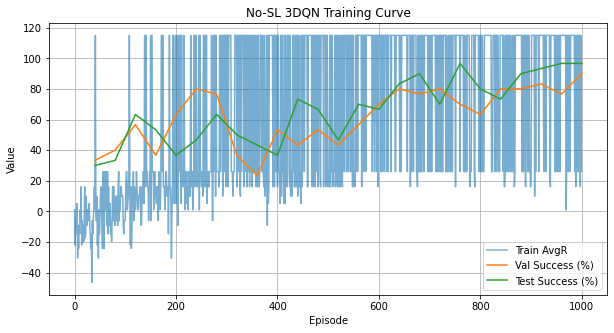

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
#  1. No-SL Environment（全新环境，只用EEG + cursor + target）
# ============================================================

class NoSLBCIEnv:
    """
    No-SL env
    """

    def __init__(self, eeg_segments, labels, success_radius=0.5):

        self.eeg_segments = eeg_segments       # (N,6,22,1000)
        self.labels = labels                   # (N,6)
        self.num_segments = len(eeg_segments)
        self.seg_len = eeg_segments.shape[1]

        self.grid_size = 20
        self.max_steps = 6
        self.success_radius = success_radius

        self.state_dim = 220 + 4

        self.action_space = 4   # 4 actions
        self.cursor_pos = None
        self.target_pos = None
        self.trial_ptr = 0
        self.steps = 0
        self.current_segment = None
        self._last_dist = None

    def _eeg_pool_features(self, eeg):
        return eeg.reshape(22, 100, 10).mean(axis=1).flatten()

    def _build_state(self, eeg):
        eeg_feat = self._eeg_pool_features(eeg)
        return np.concatenate([eeg_feat, self.cursor_pos, self.target_pos]).astype(np.float32)

    # ==================== reset ====================
    def reset(self):
        idx = np.random.randint(0, self.num_segments)
        self.current_segment = self.eeg_segments[idx]
        label_seq = self.labels[idx]

        self.cursor_pos = np.array([10.0, 10.0], dtype=np.float32)
        label = int(label_seq[-1])

        target_dict = {
            1: np.array([-5, 0]),
            2: np.array([5, 0]),
            3: np.array([0, -5]),
            4: np.array([0, 5])
        }
        self.target_pos = np.clip(self.cursor_pos + target_dict[label], 0, self.grid_size - 1)

        self._last_dist = np.linalg.norm(self.cursor_pos - self.target_pos)

        self.trial_ptr = 0
        self.steps = 0

        eeg = self.current_segment[0]
        return self._build_state(eeg), {}

    # ==================== step ====================
    def step(self, action):

        self.steps += 1

        move_map = {
            0: np.array([0, 1]),
            1: np.array([0, -1]),
            2: np.array([-1, 0]),
            3: np.array([1, 0])
        }
        self.cursor_pos = np.clip(
            self.cursor_pos + move_map[action],
            0, self.grid_size - 1
        )

        # reward
        dist = np.linalg.norm(self.cursor_pos - self.target_pos)
        reward = (self._last_dist - dist) * 8      
        reward -= 1                                 

        done = False
        if dist < self.success_radius:
            reward += 80
            done = True

        self._last_dist = dist

        self.trial_ptr += 1
        if self.trial_ptr < self.seg_len:
            eeg = self.current_segment[self.trial_ptr]
            next_state = self._build_state(eeg)
        else:
            next_state = np.zeros(self.state_dim).astype(np.float32)
            done = True

        if self.steps >= self.max_steps:
            done = True

        return next_state, reward, done, False, {}


# ============================================================
#  2. 3DQN（Dueling + Double + DQN）
# ============================================================

class DuelingQ(nn.Module):
    def __init__(self, state_dim, action_dim, hidden=256):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(state_dim, hidden),
            nn.ReLU(),
        )
        self.v = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
        self.a = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, action_dim)
        )

    def forward(self, x):
        h = self.f(x)
        v = self.v(h)
        a = self.a(h)
        return v + (a - a.mean(dim=1, keepdim=True))


class Replay:
    def __init__(self, cap=8000):
        self.buf = deque(maxlen=cap)

    def push(self, s,a,r,ns,d):
        self.buf.append((s,a,r,ns,d))

    def sample(self, bs):
        batch = random.sample(self.buf, bs)
        s,a,r,ns,d = zip(*batch)
        return (
            torch.FloatTensor(np.array(s)).to(device),
            torch.LongTensor(a).to(device),
            torch.FloatTensor(r).to(device),
            torch.FloatTensor(np.array(ns)).to(device),
            torch.FloatTensor(d).to(device)
        )

    def __len__(self):
        return len(self.buf)


# ==================== Q update ====================
def update_q(q, tq, opt, batch, gamma=0.9):

    s,a,r,ns,d = batch
    with torch.no_grad():
        na = torch.argmax(q(ns), dim=1, keepdim=True)
        nq = tq(ns).gather(1, na).squeeze(1)
        target = r + gamma * (1 - d) * nq

    qv = q(s).gather(1, a.unsqueeze(1)).squeeze(1)
    loss = F.mse_loss(qv, target)

    opt.zero_grad()
    loss.backward()
    opt.step()

    return loss.item()


# ============================================================
#  3. Train AvgR + Val Succ + Test Succ
# ============================================================

def evaluate(env, qnet, episodes=30):
    qnet.eval()
    succ = 0
    total_r = []

    for _ in range(episodes):
        s,_ = env.reset()
        done = False
        ep_r = 0

        while not done:
            with torch.no_grad():
                a = int(torch.argmax(qnet(torch.FloatTensor(s).to(device).unsqueeze(0))))
            ns,r,done,_,_ = env.step(a)
            s = ns
            ep_r += r

            if done and np.linalg.norm(env.cursor_pos - env.target_pos) < env.success_radius:
                succ += 1

        total_r.append(ep_r)

    return succ / episodes * 100.0, np.mean(total_r)


def train_3dqn_with_curves(train_env, val_env, test_env, episodes=800):

    s,_ = train_env.reset()
    state_dim = len(s)
    action_dim = 4

    q = DuelingQ(state_dim, action_dim).to(device)
    tq = DuelingQ(state_dim, action_dim).to(device)
    tq.load_state_dict(q.state_dict())

    opt = optim.Adam(q.parameters(), lr=1e-4)
    buf = Replay()

    eps = 1.0
    eps_end = 0.05
    eps_decay = 0.995

    train_avgR = []
    val_succ_curve = []
    test_succ_curve = []
    ckpt_ep = []

    for ep in range(episodes):

        s,_ = train_env.reset()
        done = False
        total_r = 0

        while not done:
            if random.random() < eps:
                a = np.random.randint(0,4)
            else:
                a = int(torch.argmax(q(torch.FloatTensor(s).to(device).unsqueeze(0))))

            ns,r,done,_,_ = train_env.step(a)
            buf.push(s,a,r,ns,done)
            s = ns
            total_r += r

            if len(buf) > 128:
                batch = buf.sample(128)
                update_q(q, tq, opt, batch)

        eps = max(eps_end, eps * eps_decay)
        train_avgR.append(total_r)

        # soft update target
        if (ep+1) % 20 == 0:
            tq.load_state_dict(q.state_dict())

        if (ep+1) % 40 == 0:
            val_succ, _ = evaluate(val_env, q)
            test_succ, _ = evaluate(test_env, q)
            ckpt_ep.append(ep+1)
            val_succ_curve.append(val_succ)
            test_succ_curve.append(test_succ)

            print(f"[Ep {ep+1}] TrainR={total_r:.1f} | Val={val_succ:.1f}% | Test={test_succ:.1f}%")

    plt.figure(figsize=(10,5))
    plt.plot(train_avgR, label="Train AvgR", alpha=0.6)
    plt.plot(ckpt_ep, val_succ_curve, label="Val Success (%)")
    plt.plot(ckpt_ep, test_succ_curve, label="Test Success (%)")
    plt.xlabel("Episode")
    plt.ylabel("Value")
    plt.title("No-SL 3DQN Training Curve")
    plt.legend()
    plt.grid()
    plt.show()

    return q


train = np.load("data_sequences/test_id_5subj_segments.pkl", allow_pickle=True)
val   = np.load("data_sequences/val_ood_2subj_segments.pkl", allow_pickle=True)
test  = np.load("data_sequences/test_ood_2subj_segments.pkl", allow_pickle=True)

train_env = NoSLBCIEnv(train["segments"], train["labels"])
val_env   = NoSLBCIEnv(val["segments"], val["labels"])
test_env  = NoSLBCIEnv(test["segments"], test["labels"])

print("Start training No-SL 3DQN ...")
qnet = train_3dqn_with_curves(train_env, val_env, test_env, episodes=1000)

